# Tree Surgery

The core data structure in [`cotengra`](cotengra) is the 
[`ContractionTree`](cotengra.core.ContractionTree), which as well as describing 
the tree generates all the required intermediate indices and equations etc. 
This page describes some aspects of the design and ways you can modify or 
construct trees yourself.

First we just generate a small random contraction:

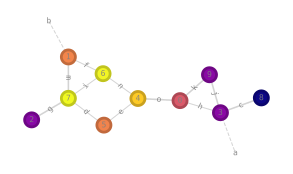

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg

# generate a random contraction
inputs, output, shapes, size_dict = ctg.utils.rand_equation(10, 3, n_out=2, seed=666)

# turn into a hypergraph in order to visualize
hg = ctg.get_hypergraph(inputs, output, size_dict)
hg.plot()

## Design

We can create an empty tree with the following:

In [2]:
tree = ctg.ContractionTree(inputs, output, size_dict)
tree

<ContractionTree(N=10, branches=0, complete=False)>

```{note}
You can also initialize an empty tree with [`ContractionTree.from_eq`](cotengra.core.ContractionTree.from_eq) or construct a completed tree with [`ContractionTree.from_path`](cotengra.core.ContractionTree.from_path) and [`ContractionTree.from_info`](cotengra.core.ContractionTree.from_info). The [`search`](cotengra.hyper.HyperOptimizer.search) method of optimizers also directly returns a tree.
```

The nodes of the tree are frozen sets of integers, describing groups of inputs which form intermediate tensors. Initially only the final output tensor (tree root node), and input tensors (tree leaf nodes) are known:

In [3]:
print(tree.root)

frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


In [4]:
for node in tree.gen_leaves():
    print(node)

frozenset({0})
frozenset({1})
frozenset({2})
frozenset({3})
frozenset({4})
frozenset({5})
frozenset({6})
frozenset({7})
frozenset({8})
frozenset({9})


In order to complete the tree we need to find $N - 1$ contractions (branches) via either merges of parentless nodes (like the leaves above) or partitions of childless nodes (like the root above). [`contract_nodes`](cotengra.core.ContractionTree.contract_nodes) is the method used to form these merges for an arbitrary set of nodes. 

Here we merge two leaves to form a new intermediate (agglomeratively building the tree from the bottom):

In [5]:
parent = tree.contract_nodes([frozenset([0]), frozenset([1])])
parent

frozenset({0, 1})

Here we split the root (divisively building the tree from the top):

In [6]:
left, right = frozenset(range(0, 5)), frozenset(range(5, 10))

# this should output the root
tree.contract_nodes([left, right])

frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Note how we can declare `left` and `right` here as intermediates even though we don't know exactly how they will be formed yet. We can already work out certain properties of such nodes for example their indices ('legs') and their size:

In [7]:
tree.get_legs(left), tree.get_size(left)

(<BitMembers(['a', 'b', 'c', 'e', 'f', 'g', 'j', 'k', 'l', 'm', 'n'])>, 15552)

But other information such as the flops required to form them need their children specified first.

In [8]:
tree.get_flops(tree.root)

31104

In [9]:
tree.get_einsum_eq(parent)

'abc,def->abcdef'

The core tree information is stored as a mapping of children like so:

In [10]:
tree.children

{frozenset({0, 1}): (frozenset({1}), frozenset({0})),
 frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9}): (frozenset({5, 6, 7, 8, 9}),
  frozenset({0, 1, 2, 3, 4}))}

We can compute the flops and any other local information for any nodes that are keys of this. This information is cached in `tree.info`.

When calling `contract_nodes` we can actually specify an arbitrary collection of (uncontracted) nodes, these can be seen as the leaves of a subtree which is a mini contraction problem in its own right. Hence the function itself takes the `optimize` kwarg used to specify how to optimize this sub contraction. Here we'll make use of this to complete our tree.

In [11]:
# fill in the subtree with `left` as root
tree.contract_nodes([parent] + [frozenset([i]) for i in range(2, 5)])

# fill in the subtree with `right` as root
tree.contract_nodes([frozenset([i]) for i in range(5, 10)])

# our tree should now be complete
tree.is_complete()

True

We can now plot our tree, check full costs, and use it perform contractions etc:

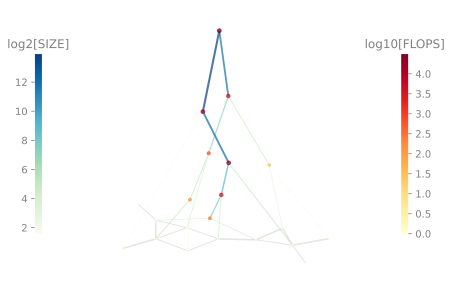

In [12]:
tree.plot_tent()

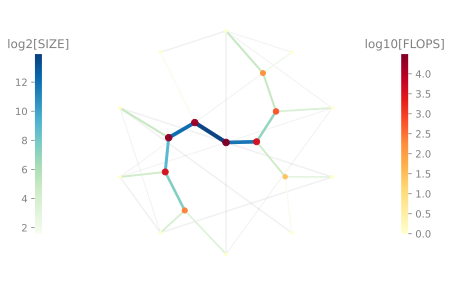

In [13]:
tree.plot_ring()

In [14]:
tree.contraction_width(), tree.contraction_cost()

(13.92481250360578, 37849.0)

In [15]:
import numpy as np
arrays = [np.random.randn(*s) for s in shapes]
tree.contract(arrays)

array([[-30.0992929 , -30.73021734],
       [ 24.78729968,  28.86578091]])

We can also generate an explicit **contraction path**, which is a specific ordering of the tree (the default for exact contractions being depth first) and the format used by `opt_einsum` and accepted by `quimb` too:

In [16]:
path = tree.get_path()
path

((5, 7), (5, 8), (5, 6), (5, 6), (0, 1), (2, 4), (1, 3), (0, 2), (0, 1))

Once we have a complete tree, either by explicitly building it or more likely as returned by an optimizer, we can also *modify* in various ways as detailed below. 

## Index Slicing

Slicing is the technique of choosing some indices to explicitly sum over rather than include as tensor dimensions - thereby takng indexed slices of those tensors. It is also known as **variable projection** and **bond cutting**. The overall effect is to turn a single contraction into many independent, easier contractions as depicted below:

<p align="center"><img src="https://imgur.com/402ivDV.png" alt="cotengra" width="80%" height="80%"></p>

While slicing *every* index would be equivalent to performing the naive einsum and thus exponentially slower, carefully choosing just a few *can* result in little to no overhead. What you gain is:

1. **Each contraction can require drastically less memory**
2. **Each contraction can be performed in parallel**

In general, one specifies slicing in the `HyperOptimizer` loop - see [Slicing and Subtree Reconfiguration](advanced.ipynb#slicing-and-subtree-reconfiguration) - this section covers manually slicing a tree and the details.

In [17]:
import opt_einsum as oe

# create a reasonable large random contraction:
eq, shapes = oe.helpers.rand_equation(n=50, reg=5, seed=42, d_max=2)
arrays = [np.random.uniform(size=s) for s in shapes]
eq

'ÓøÅÁ,dÛuÃD,WáYÔÎ,EĄÏZ,ÄPåÍ,æuëX,îĆxò,ègMÑza,eNS,À,ðÙÖ,øĂTê,ĂÏĈ,Ąąô,HóÌ,üÂÿØãÈ,íËòPh,hÐÓMç,äCFÁU,mGùbB,ćÐnë,jQãrkñÜ,ÅÚvóćS,IÒöõĀú,äþözbKC,wâTiZ,BfĆd,fàÉìúå,pVwç÷,ÈQXÙGñJ,ðÆôA,qËÜÝyR,ÒüÊnÞ×cÔVþā,ùïà,mßclYÄÌÉx÷,ÃrÕÿ,jolÚ,îosE,æÇD×,ÛăHvýûõ,ÇÎRNØ,WÊÀáÍéê,Âes,èJAÖ,ûÝFÆ,iïíÞtìă,ÕqOL,IāLéUaĈÑg,âKpýOą,tĀyßk->'

In [18]:
# start with a simple greedy contraction path / tree
_, info = oe.contract_path(eq, *arrays, optimize='greedy')
tree = ctg.ContractionTree.from_info(info)

# check the time and space requirements
tree.contraction_cost(), tree.contraction_width()

(71044941088.0, 25.0)

We can call the [`slice`](cotengra.core.ContractionTree.slice) method of a tree 
to slice it.

In [19]:
tree_s = tree.slice(target_size=2**20)

```{hint}
This method and various others can also be called inplace with a trailing underscore.
```

In [20]:
tree_s.sliced_inds, tree_s.nslices

(('b', 'd', 'y', 'Æ', 'Î', 'ă'), 64)

In [21]:
# check the new time and space requirements
tree_s.contraction_cost(), tree_s.contraction_width()

(74463566848.0, 20.0)

The tree now has 6 indices sliced out, and represents 64 individual 
contractions each requiring 32x less memory. The total cost has increased 
slightly, this ***'slicing overhead'*** we can check:

In [22]:
tree_s.contraction_cost() / tree.contraction_cost()

1.0481192004335047

So less than 5% more floating point operations overall, (arising from 
redundantly repeated contractions).

```{note}
Internally, the tree constructs a [`SliceFinder`](cotengra.slicer.SliceFinder)
object and uses it to search for good indices to slice. For full control, you 
could do this yourself and then call manually call 
[`remove_ind`](cotengra.core.ContractionTree.remove_ind) on the tree.
```

Once a [ContractionTree](cotengra.core.ContractionTree) has been sliced, the
[contract](cotengra.core.ContractionTree.contract) method can be used to 
automatically perform the sliced contraction:

In [23]:
tree_s.contract(arrays, progbar=True)

100%|██████████| 64/64 [00:03<00:00, 20.34it/s]


1.0696244850445234e+23

See the [main contraction page](contraction.ipynb) for more details on
performing the actual sliced contraction once the indices have been found.

## Subtree Reconfiguration

Any subtree of a contraction tree itself describes a smaller contraction, with 
the subtree leaves being the effective inputs (generally intermediate tensors) 
and the subtree root being the effective output (also generally an 
intermediate). One advantage of cotengra keeping an explicit representation of 
the contraction tree is that such subtrees can be easily selected and 
re-optimized as illustrated in the following schematic:

<p align="center"><img src="https://imgur.com/vi60oh7.png" alt="cotengra" width="100%" height="100%"></p>

(Note in general the subtree being optimized will be closer in size to 10 
intermediates or so.)

If we do this and improve the contraction cost of a **subtree** (e.g. by using an optimal contraction path), then the contraction cost of the **whole tree** is improved. Moreover we can iterate across many or all subtrees in a `ContractionTree`, reconfiguring them and thus potentially updating the entire tree in incremental 'local' steps.

The method to call for this is 
[`subtree_reconfigure`](cotengra.core.ContractionTree.subtree_reconfigure).

In [24]:
# generate a tree
eq, shapes = oe.helpers.rand_equation(100, 3, seed=42)
path, info = oe.contract_path(eq, *shapes, shapes=True)
tree = ctg.ContractionTree.from_info(info)

# reconfigure it (call tree.subtree_reconfigure? to see many options)
tree_r = tree.subtree_reconfigure(progbar=True)

log2[SIZE]: 41.33 log10[FLOPs]: 14.68: : 208it [00:00, 412.55it/s]


In [25]:
# check the speedup
tree.total_flops() / tree_r.total_flops()

12803.1423636353

Since it is a local optimization it is possible to get stuck. 
[`subtree_reconfigure_forest`](cotengra.core.ContractionTree.subtree_reconfigure_forest)
offers a basic stochastic search of multiple reconfigurations that can avoid this and also be easily parallelized:

In [32]:
tree_f = tree.subtree_reconfigure_forest(progbar=True, num_trees=4)

log2[SIZE]: 39.24 log10[FLOPs]: 14.54: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


In [33]:
# check the speedup
tree.total_flops() / tree_f.total_flops()

17928.323601154407

So indeed a little better.

Subtree reconfiguration is often powerful enough to allow even 'bad' initial paths (like those generated by `'greedy'` ) to become very high quality.

## Dynamic Slicing

A powerful application for reconfiguration (first implemented in ['Classical Simulation of Quantum Supremacy Circuits'](https://arxiv.org/abs/2005.06787)) is to interleave it with *slicing*. Namely:

1. Choose an index to slice
2. Reconfigure subtrees to account for the slightly different TN structure without this index
3. Check if the tree has reached a certain size, if not return to 1.

In this way, the contraction tree is slowly updated to account for potentially many indices being sliced.

For example imagine we wanted to slice the ``tree_f`` from above to achieve a maximum size of `2**28` (approx suitable for 8GB of memory). We could directly slice it without changing the tree structure at all:

In [34]:
tree_s = tree_f.slice(target_size=2**28)
tree_s.sliced_inds

('O', 'W', 'k', 'o', 'Ñ', 'ì')

Or we could simultaneously interleave subtree reconfiguration:

In [35]:
tree_sr = tree_f.slice_and_reconfigure(target_size=2**28, progbar=True)
tree_sr.sliced_inds

log2[SIZE]: 27.51 log10[FLOPs]: 14.81: : 5it [00:00,  8.94it/s]


('O', 'W', 'k', 'o', 'Ñ')

In [36]:
tree_s.total_flops() / tree_sr.total_flops()

2.0505093335393947

We can see it has achieved the target size with 1 less index sliced, and 2x better cost. There is also a 'forested' version of this algorithm  which again performs a stochastic search of multiple possible slicing+reconfiguring options:

In [37]:
tree_fsr = tree_f.slice_and_reconfigure_forest(target_size=2**28, progbar=True)
tree_s.total_flops() / tree_fsr.total_flops()

log2[SIZE]: 26.87 log10[FLOPs]: 14.72: : 11it [00:02,  4.57it/s]


2.511722935482458

We can see here it has done a little better. The foresting looks roughly like the following:

<p align="center"><img src="https://imgur.com/s1iSS1u.png" alt="cotengra" width="100%" height="100%"></p>

The subtree reconfiguration within the slicing can *itself be forested* for a doubly forested algorithm. This will give the highest quality (but also slowest) search.


In [38]:
tree_fsfr = tree_f.slice_and_reconfigure_forest(
    target_size=2**28,
    num_trees=4,
    progbar=True,
    reconf_opts={
        'subtree_size': 12,
        'forested': True,
        'num_trees': 4,
    }
)

log2[SIZE]: 39.24 log10[FLOPs]: 14.54: : 0it [00:00, ?it/s]

In [ ]:
tree_s.total_flops() / tree_fsfr.total_flops()

We've set the `subtree_size` here to `12` for higher quality reconfiguration, but reduced the `num_trees` in the forests (from default `8`) to `4` which will still lead to 4 x 4 = 16 trees being generated at each step. Again we see a slight improvement. This level of effort might only be required for very heavily slicing contraction trees, and in this case it might be best simply to trial many initial paths with a basic `slice_and_reconfigure` (see below).